# **Hit Song Attributes**

# Project: Milestone 3

## Cleaning/Formatting Website Data

Amelia Farrell

DSC540

4/27/23

## Step 1: Load and Understanding the data

We need to first read and understand the website data. This will help us know what transformations are needed.

In [29]:
# importing libraries needed
import pandas as pd
import requests
import re
import hashlib

In [ ]:
# Loading the website data into a list
url = "https://en.wikipedia.org/wiki/List_of_Billboard_Year-End_number-one_singles_and_albums"
r = requests.get(url)
df_list = pd.read_html(r.text) # this parses all the tables in webpages to a list

In [ ]:
# creating a dataframe of the list
df = df_list[0]
# viewing the dataframe with headers and first rows
df.head()

Year                                                Pop        \
   Year                                             Single Album   
0  1946                   "Prisoner of Love"[1] Perry Como     —   
1  1947                        "Near You"[4] Francis Craig     —   
2  1948               "Twelfth Street Rag"[7] Pee Wee Hunt     —   
3  1949    "Riders in the Sky"[10] Vaughn Monroe Orchestra     —   
4  1950  "Goodnight, Irene"[13] Gordon Jenkins and The ...     —   

                                    R&B/Soul/Hip-hop        \
                                              Single Album   
0              "Hey! Ba-Ba-Re-Bop"[2] Lionel Hampton     —   
1  "Ain't Nobody Here But Us Chickens"[5] Louis J...     —   
2                      "Long Gone"[8] Sonny Thompson     —   
3                 "The Hucklebuck"[11] Paul Williams     —   
4                   "Pink Champagne"[14] Joe Liggins     —   

                                             Country        
                                              Single Album  
0                "New Spanish Two Step"[3] Bob Wills     —  
1  "Smoke! Smoke! Smoke! (That Cigarette)"[6] Tex...     —  
2                  "Bouquet of Roses"[9] Eddy Arnold     —  
3  "Lovesick Blues"[12] Hank Williams and the Dri...     —  
4                      "I'm Movin' On"[15] Hank Snow     —

As we can see in the data above, our Website breaks out the top songs by year AND by genre. This is not what we are looking for. We want the top song of the year regardless of the genre. Due to this discovery, we needed to investigate whether or not this website data could even work for our analysis. If we only look at one genre, are we missing some of the top songs from our Flat File? As it turns out, the Pop songs are typically (if not always) the top song of the year. This makes a lot of sense. Due to this, we will be looking at only the top ‘Pop’ songs from the website data. To achieve this, we will need to perform the data preparation steps that we will continue below.

## Step 2: Remove Columns 

In [ ]:
# removing columns not needed. Only keeping the "Pop" column
df2 = df.drop(df.columns[[2, 3, 4, 5, 6]], axis=1)
df2.head()

,Year,Pop
,Year,Single
0,1946,"""Prisoner of Love""[1] Perry Como"
1,1947,"""Near You""[4] Francis Craig"
2,1948,"""Twelfth Street Rag""[7] Pee Wee Hunt"
3,1949,"""Riders in the Sky""[10] Vaughn Monroe Orchestra"
4,1950,"""Goodnight, Irene""[13] Gordon Jenkins and The ..."


## Step 3: Check for missing and duplicate values

In [ ]:
# checking for missing vaules
missing_values = df2.isnull()
# count the number of missing values in each column
num_missing = missing_values.sum()
# print result
print(num_missing)

Year  Year      0
Pop   Single    0
dtype: int64


No missing values!

In [ ]:
# checking for duplicates
duplicates = df2.duplicated()
# filter the DataFrame to keep only the duplicate rows
duplicate_rows = df2.duplicated(keep=False)
filtered_df = df2[duplicate_rows]
# print the filtered DataFrame
print(filtered_df)

Empty DataFrame
Columns: [(Year, Year), (Pop, Single), (is_duplicate, )]
Index: []


The above states that we have no duplicate values. However, looking closer at the data, you can see other problems where there are two songs listed as the "top" for the year. This was due to conflicting options and wikipedia deciding to not choose a side, but to just list both songs as the "top". Which is great but for our analysis, we only need one… So we will have to choose which song is our “top”. How do we do that? Luckily our Wikipedia table references other sites as to why the song was listed as number one. Some songs have more references than others. So we decided that any song with more references, is the #1 song of that year.

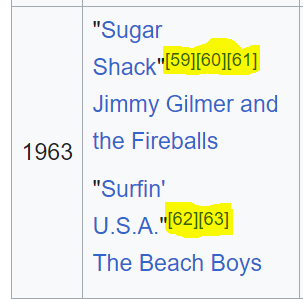

## Step 4: Creating cleaning function 

As there are many steps that need to be applied toeach row of our data, we created a function to preform the below steps.

1.   Isolate the name of the song from song&artist string using regex
2.   Isolate the name of the artist from song&artist string using regex
3.   Check if the year has more than one song
4.   If it does have more than one song, find the number of refrences
5.   Select the song with the higher number of refrences
5.   Repeat step 4 for artist
6.   After there is only one song, strip the quotes song name
7.   Strip refrences from artist
8.   Return the new row for each line from the table



In [ ]:
def seperate_values(row):
  r = re.compile(r"\"\D+\"") # getting the song name using regex
  a = re.compile(r"(\[\d+\])+(.*)") # getting the song artist using regex
  song_count = r.findall(row["Name"]) 
  artist_list = r.split(row["Name"])

  # Checks if the year has more the one song if so
  # picks song based on how many refrences it has. 
  # Song with the most refrences wins
  if len(song_count) > 1:
    count=0
    for x, artist in enumerate(artist_list):# split string by matches. Leaves artist and refrence makers (these are what is used to find the "winning" (most refrenced) song)
      if artist.count("[") > count: # if number of refrences is greater then the last, update the count and set winning index 
        count = artist.count("[")
        art_index = x


    song_name=song_count[art_index-1].replace("\"", "").strip("/") # set song name by the index chosen with most refrences
    song_artist=a.search(artist_list[art_index]).group(2).strip() # set song artist by the index chosen with most refrences
  else:
    song_name=song_count[0].replace("\"", "").strip("/") # strip/removed quotes from song name
    song_artist=a.search(artist_list[1]).group(2).strip() # strip/removed refrences from song artist

  row["Name"]=song_name # remame column
  row["Artist"]=song_artist # remame column
  return row

## Step 5: Running our function

In [ ]:
# changing column names
df3 = df2.set_axis(['Year', 'Name'], axis=1)
# seperating out song name and artist by running the seperate_values function
df4 = df3.apply(seperate_values, axis=1)
# lowercase all values
df4['Name'] = df4['Name'].str.lower() 
df4['Artist'] = df4['Artist'].str.lower()
# viewing the new dataframe with headers and first rows
df_wiki = df4
df_wiki

,Year,Name,Artist
0,1946,prisoner of love,perry como
1,1947,near you,francis craig
2,1948,twelfth street rag,pee wee hunt
3,1949,riders in the sky,vaughn monroe orchestra
4,1950,"goodnight, irene",gordon jenkins and the weavers
...,...,...,...
72,2018,god's plan,drake
73,2019,old town road,lil nas x featuring billy ray cyrus
74,2020,blinding lights,the weeknd
75,2021,levitating,dua lipa


##  Step 5: Unique Identifier

As we has crreated a Unique Identifier is our flat file, we will also create one here. Combining the 'Song_Name' and 'Song_Artist' to check for duplicates. However, if we just combine the two columns, it will carry over the spaces from the song names and artists. This is not the best way to create a unique identifier. Rather than having messy unique identifiers with spaces, we will create a hash for each.

In [ ]:
# changing column names
df_wiki2 = df_wiki.set_axis(['year', 'song_name','song_artist'], axis=1)

In [30]:
# creating our own hashing function that will loop through each row and create our unique identifier (done in each dataset)
def hash_function(row):
  combined=("{}{}".format(row['song_name'],row['song_artist'])).encode('utf-8')
  row['uid'] = hashlib.md5(combined).hexdigest()
  return row

df_wiki3 = df_wiki2.apply(hash_function, axis=1)

# viewing new data set with hash (Unique Identifier (uid))
df_wiki3.head()


,year,song_name,song_artist,uid
0,1946,prisoner of love,perry como,5ffa72f4e33500df9151c0ca490e9758
1,1947,near you,francis craig,a765d8bda8572ac7980ec49d5d645f15
2,1948,twelfth street rag,pee wee hunt,72f21b83776b80770dae54606fff03d0
3,1949,riders in the sky,vaughn monroe orchestra,8c3661637a4ab864521e13a379b16b17
4,1950,"goodnight, irene",gordon jenkins and the weavers,51abcf5725b1806fb1fdf89cabc0a7bd
